In [1]:
import os
import datetime
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from harc_plot import geopack
%matplotlib inline

Re = 6371 # Radius of the Earth in km

## Define Station Locations

In [2]:
tx = {}
tx['st_id'] = 'WWV'
tx['lat']   =  40.68
tx['lon']   = -105.04

In [3]:
grapes = []

g = {}
g['st_id'] = 'kd2uhn'
g['lat']   =  40.6332
g['lon']   = -74.98881
g['color'] = 'purple'
grapes.append(g)

g = {}
g['st_id'] = 'n2rkl'
g['lat']   =  43.16319
g['lon']   = -76.12535
g['color'] = 'green'
grapes.append(g)

g = {}
g['st_id'] = 'n8obj'
g['lat']   =  41.321963
g['lon']   = -81.504739
g['color'] = 'red'
grapes.append(g)

grapes = pd.DataFrame(grapes)
grapes = grapes.set_index('st_id')
grapes

,lat,lon,color
st_id,,,
kd2uhn,40.633200,-74.988810,purple
n2rkl,43.163190,-76.125350,green
n8obj,41.321963,-81.504739,red


## Calculate midpoints between Transmitter and Receivers

In [4]:
grapes

grapes_new = []
for rinx, row in grapes.iterrows():
    # print(rinx)
    lat = row['lat']
    lon = row['lon']
    
    azm = geopack.greatCircleAzm(tx['lat'],tx['lon'],lat,lon)
    rng = geopack.greatCircleDist(tx['lat'],tx['lon'],lat,lon)*Re
    res = geopack.greatCircleMove(tx['lat'],tx['lon'],rng/2.,azm,alt=0,Re=Re)
    
    row['mid_lat'] = res[0][0]
    row['mid_lon'] = res[1][0]
    
    grapes_new.append(row)
    
grapes = pd.DataFrame(grapes_new)
grapes

,lat,lon,color,mid_lat,mid_lon
kd2uhn,40.633200,-74.988810,purple,41.644169,-90.009011
n2rkl,43.163190,-76.125350,green,42.839187,-90.870155
n8obj,41.321963,-81.504739,red,41.604411,-93.330499


## Load Eclipse Data

In [5]:
def load_eclipse_df(fname,path='data/eclipse_paths'):
    fpath = os.path.join(path,fname)

    names     = ['date_str','time_str','utc_hr','obsc','lat','lon']
    def date_parser(date_str,time_str):
        dt_str = ('{!s} {!s}'.format(date_str,time_str)).strip()
        date   = datetime.datetime.strptime(dt_str,'%Y/%m/%d %H:%M:%S')
        return date

    ecl_paths = pd.read_table(fpath,sep='\s+',names=names,parse_dates={'date':[0,1]},date_parser=date_parser)
    ecl_paths.set_index('date',inplace=True)

    return ecl_paths

fnames = []
fnames.append('eclipse20231014.txt.150km.hiRes')
fnames.append('eclipse20231014.txt.300km.hiRes')
fnames.append('eclipse20240408.txt.150km.hiRes')
fnames.append('eclipse20240408.txt.300km.hiRes')

eclipses = {}
for fname in fnames:
    date     = fname[7:15]
    date_key = int(date)
    ecl_date = datetime.datetime.strptime(date,'%Y%m%d')
    alt      = int(fname.split('.')[2][:-2])
    
    if date not in eclipses:
        eclipses[date] = {}
        
    ecl = eclipses[date][alt] = {}
    
    ecl['fname'] = fname
    ecl['label'] = '{!s} - {!s} km'.format(ecl_date.strftime('%Y %b %d'),alt)
    ecl['path']  = load_eclipse_df(fname)

/home/w2naf/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


In [6]:
# Plot Eclipse Paths
for date_key,alt_dct in eclipses.items():
    for alt,ecl in alt_dct.items():
        print(ecl['label'])

2023 Oct 14 - 150 km
2023 Oct 14 - 300 km
2024 Apr 08 - 150 km
2024 Apr 08 - 300 km


## Plot on a Map

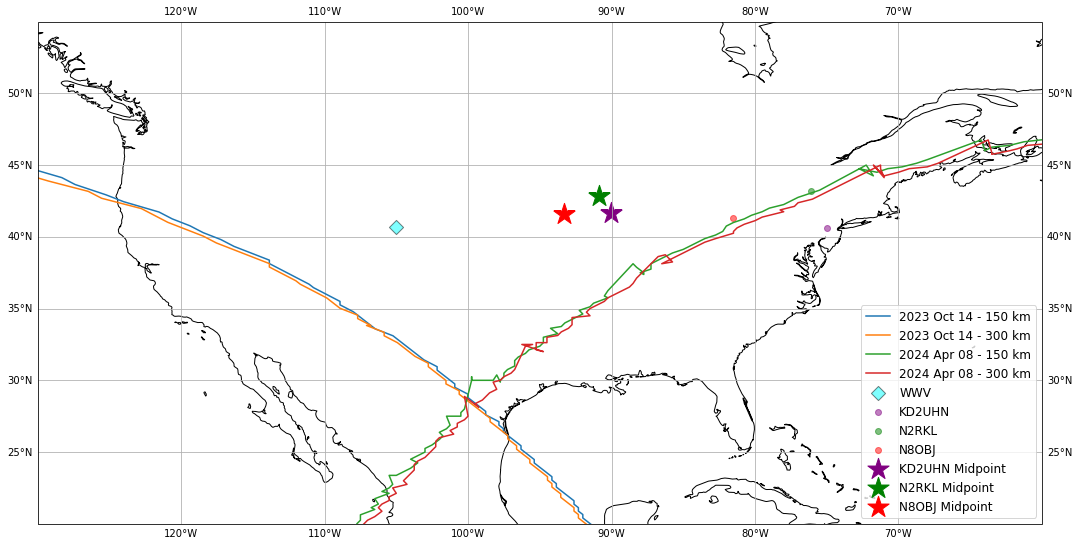

In [7]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax  = fig.add_subplot(1,1,1,projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot Eclipse Paths
for date_key,alt_dct in eclipses.items():
    for alt,ecl in alt_dct.items():
        label = ecl['label']
        path  = ecl['path']
        
        xx    = path['lon']
        yy    = path['lat']
        alpha = path['obsc']

        # ax.scatter(xx,yy,alpha=alpha,label=label)
        ax.plot(xx,yy,label=label)
        
        # # Try polyfit to make smoother???
        # coefs = np.polyfit(xx,yy,4)
        # p     = np.poly1d(coefs)
        # yyp = p(xx)
        # ax.plot(xx,yyp,label=label)

alpha = 0.5
# Plot Transmitter
ax.scatter(tx['lon'],tx['lat'],marker='D',s=100,color='Cyan',label=tx['st_id'],ec='black',alpha=alpha)

# Plot Ground Locations of Grapes
for rinx,row in grapes.iterrows():
    lat   = row['lat']
    lon   = row['lon']
    label = rinx.upper()
    color = row['color']
    ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],alpha=alpha)
    
# Plot Grape Midpoints
for rinx,row in grapes.iterrows():
    lat   = row['mid_lat']
    lon   = row['mid_lon']
    label = '{!s} Midpoint'.format(rinx.upper())
    color = row['color']

    ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],marker='*',s=500)

ax.legend(loc='lower right',fontsize='large')
    
# # World Limits
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)

# US Limits
ax.set_xlim(-130,-60)
ax.set_ylim(20,55)

plt.show()